In [1]:
from utils.data_handling import *
from utils.sensor_optimisation_tsvd import *
from parameters import *
import GPy
import scipy.stats

import matplotlib.pyplot as plt
np.random.seed(101)



### Importing the Tracer Data to Select the Optimisation set S

In [2]:
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [4]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [5]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [6]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


In [7]:
#A_list = set_to_onehot(S,data_df.shape[0])
#save_vtu(ref_vtu[0],'FinalSelection',A_list)

### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [8]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [9]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [10]:
X = loc_df.values[:,:] #[I,:dim]
Z = data_df.values[:,:]#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [11]:
Z[S,:] = (Z[S,:]  - Z[S,:].mean(axis=1,keepdims=True))

PCA tests

In [12]:
from sklearn.decomposition import PCA

from sklearn.covariance import *


In [59]:
model = GraphicalLasso(
    alpha=0.01,
    mode='cd',
    tol=0.0001,
    enet_tol=0.0001,
    max_iter=100,
    verbose=True,
    assume_centered=False)

In [ ]:
model.fit(Z[S,:].T)

In [ ]:
model.covariance_.shape

In [13]:
cov_emp = empirical_covariance(Z[S,:].T)
cov_emp.shape

(23643, 23643)

In [14]:
print(np.linalg.slogdet(cov_emp))

(-1.0, -1399936.2860277274)


In [105]:
eig_emp = np.linalg.eigvalsh(cov_emp)

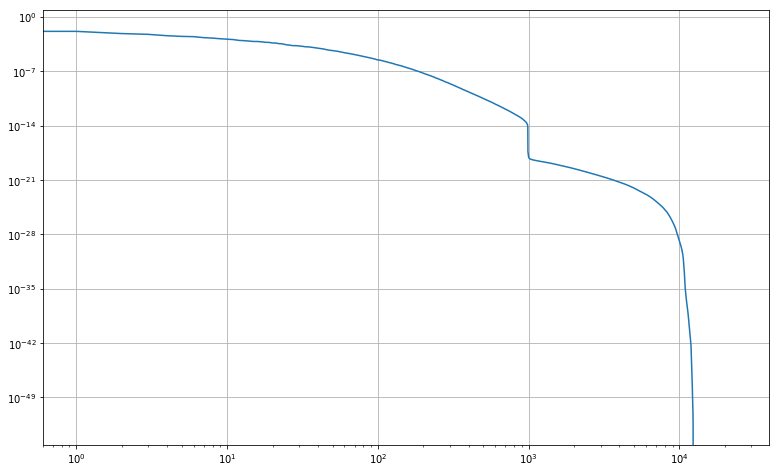

In [110]:
plt.figure(figsize=(13,8))
plt.loglog(eig_emp[::-1])
plt.grid()

In [15]:
cov_np = np.cov(Z[S,:])
cov_np.shape

(23643, 23643)

In [16]:
print(np.linalg.slogdet(cov_np))

(-1.0, -1399902.7259884884)


In [17]:
cov_oas = oas(Z[S,:].T)
cov_oas[0].shape

(23643, 23643)

In [18]:
cov_oas[0]

array([[ 2.94410328e-08,  8.34050388e-15, -1.26981376e-09, ...,
        -4.40232159e-23, -6.59736285e-26, -8.84706691e-26],
       [ 8.34050388e-15,  2.94350276e-08, -7.73020912e-12, ...,
         2.87754370e-24, -1.02917247e-27, -1.07849477e-27],
       [-1.26981376e-09, -7.73020912e-12,  2.18794450e-05, ...,
        -2.86196576e-19, -1.97136944e-22, -1.98808304e-22],
       ...,
       [-4.40232159e-23,  2.87754370e-24, -2.86196576e-19, ...,
         2.94350275e-08, -3.43158937e-35, -2.42067953e-35],
       [-6.59736285e-26, -1.02917247e-27, -1.97136944e-22, ...,
        -3.43158937e-35,  2.94350275e-08,  1.27893672e-37],
       [-8.84706691e-26, -1.07849477e-27, -1.98808304e-22, ...,
        -2.42067953e-35,  1.27893672e-37,  2.94350275e-08]])

In [19]:
cov_oas[1]

0.00875954625157332

In [20]:
np.linalg.slogdet(cov_oas[0])

(1.0, -408903.3383689516)

In [22]:
eig_oas = np.linalg.eigvalsh(cov_oas[0])


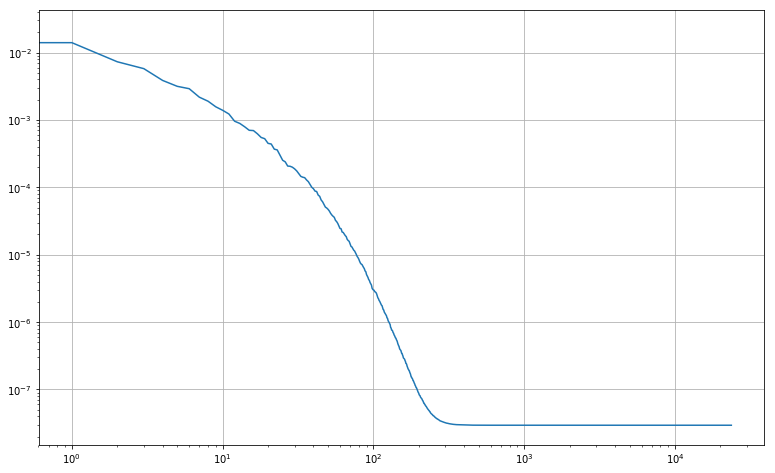

In [111]:
plt.figure(figsize=(13,8))
plt.loglog(eig_oas[::-1])
plt.grid()

In [100]:
model = ShrunkCovariance(store_precision=True, assume_centered=False, shrinkage=0.1)

In [101]:
model.fit(Z[S,:].T)

ShrunkCovariance(assume_centered=False, shrinkage=0.1, store_precision=True)

In [102]:
cov_shrink = model.covariance_

In [26]:
eig_shrinkage = np.linalg.eigvalsh(cov_shrink)

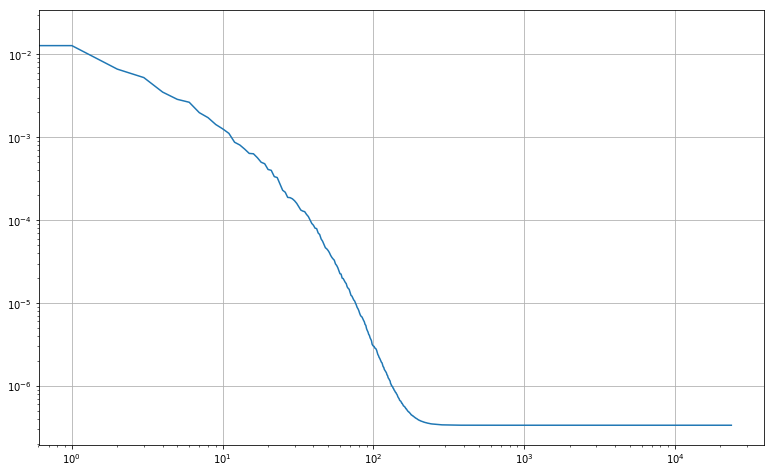

In [112]:
plt.figure(figsize=(13,8))
plt.loglog(eig_shrinkage[::-1])
plt.grid()

In [28]:
model = PCA(n_components=40)

In [29]:
model.fit(Z[S,:].T)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [30]:
cov_pca = model.get_covariance()

In [113]:
eig_pca = np.linalg.eigvalsh(cov_pca)

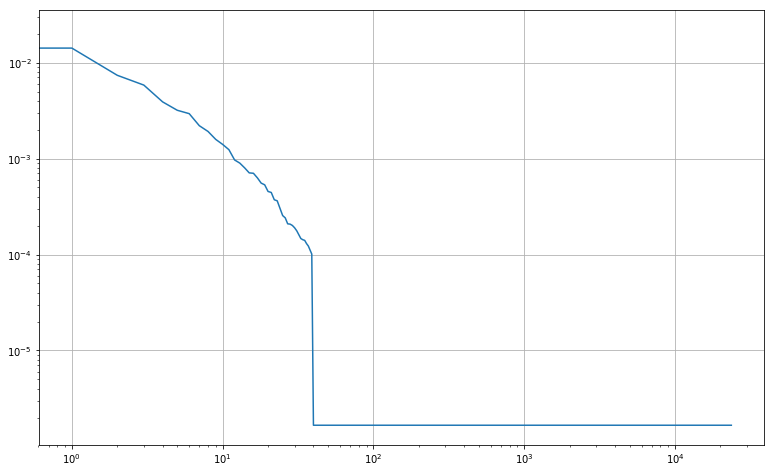

In [115]:
plt.figure(figsize=(13,8))
plt.loglog(eig_pca[::-1])
plt.grid()

In [34]:
np.linalg.slogdet(cov_pca)

(1.0, -314378.3192036518)

In [25]:
cov = (Z[S,:] @ Z[S,:].T)/Z[S,:].shape[0]

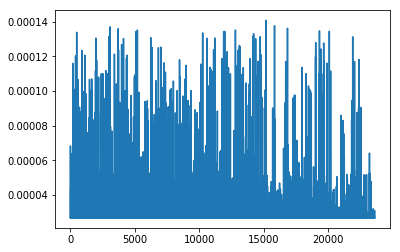

In [20]:
model.transform(Z[S,:].T).T.shape

(50, 989)

 /home/aml718/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:invalid value encountered in log


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd9c9c152f0> (for post_execute):


KeyboardInterrupt: 

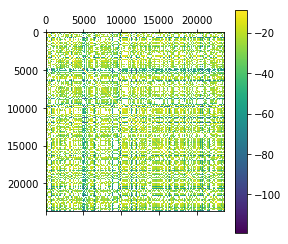

In [79]:
plt.matshow(np.log((cov_pca[:,:])))
plt.colorbar()

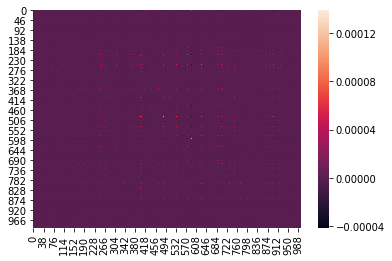

In [41]:
import seaborn as sns
sns.heatmap(((cov_oas[0][:1000,:1000])))


In [46]:
np.argsort(cov_oas[0][10,:])

array([18304,  6834,   592, ..., 12045,  4416, 13971])

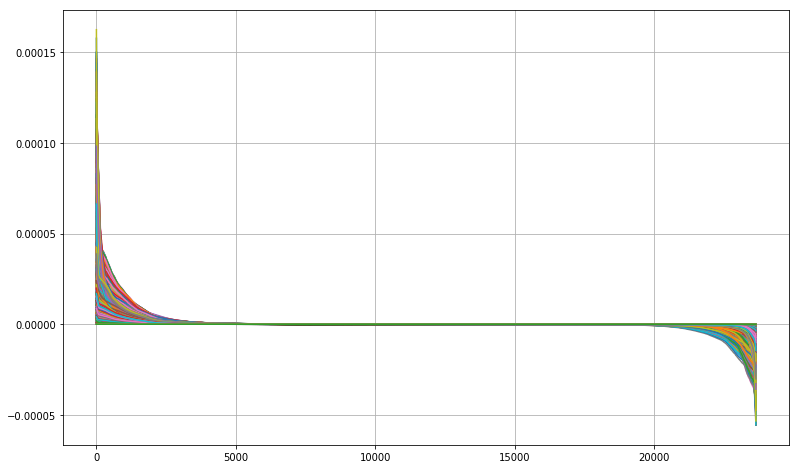

In [97]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_oas[0][:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

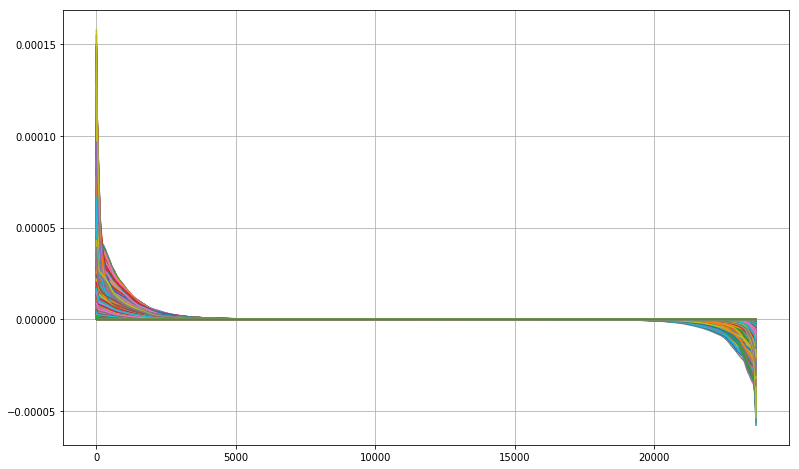

In [99]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_pca[:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

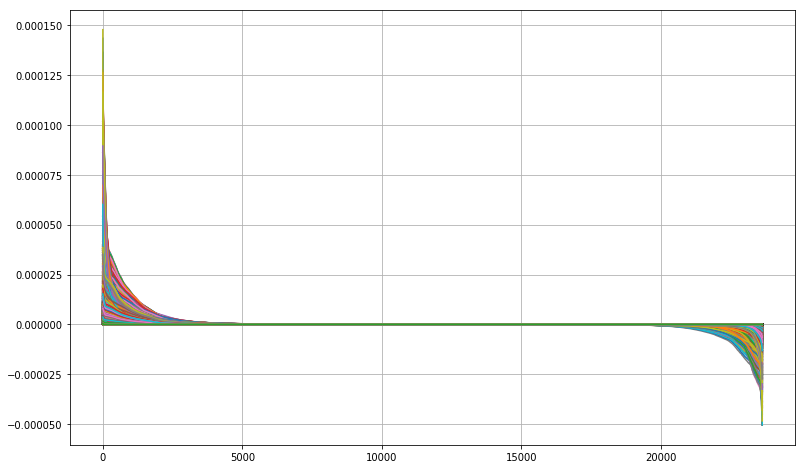

In [103]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_shrink[:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

In [77]:
np.sort(cov_oas[0][0:10,:],axis=0)[:,::-1]

array([[-1.09359724e-21, -1.21315756e-21, -2.86196576e-19, ...,
        -1.26981376e-09, -7.73020912e-12, -1.26981376e-09],
       [-1.98808304e-22, -1.97136944e-22, -4.40232159e-23, ...,
        -9.33966931e-10, -8.05147016e-25, -7.55173027e-16],
       [-2.89847596e-23, -2.97426411e-23, -3.00347665e-25, ...,
        -7.73020912e-12, -9.27859284e-30, -8.76411801e-23],
       ...,
       [ 6.72407821e-40,  6.61677520e-40,  4.30470781e-23, ...,
         1.80585927e-07,  4.03122538e-13,  2.78924662e-11],
       [ 2.70585478e-35,  6.01906151e-35,  1.04164505e-20, ...,
         1.68260116e-06,  6.91716894e-12,  3.33832513e-09],
       [ 1.70836720e-27,  1.54818600e-27,  1.24967501e-18, ...,
         2.18794450e-05,  2.94350276e-08,  2.94410328e-08]])

In [ ]:
plt.pcolormesh(((cov_pca[:,:])))


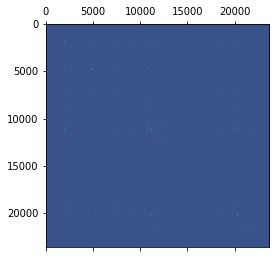

In [30]:
plt.matshow(cov)

In [52]:
np.linalg.norm(cov_np-cov_pca)

0.00019691706064742899

In [53]:
np.linalg.det(cov_pca)

0.0

### Sensor Optimisation with TSVD : 


Define the Sets for the optimisation

In [10]:
sets = define_sets(S)

Number of sensors to place : 

In [11]:
k = 5

Truncation parameteter for the TSVD : 

In [12]:
tau = 50

In [13]:
A_opt = {}

In [14]:
A_opt['lazy'] = sensor_loc_optimisation_lazy(k,Z, sets, tau)

Inner Loop:   0%|          | 62/57725 [02:48<42:11:34,  2.63s/it]

KeyboardInterrupt: 

In [ ]:
A_opt['naive'] = sensor_loc_optimisation_naive(k,Z, sets, tau)

In [ ]:
A_opt['lazy'] 

In [ ]:
A_opt['naive']

In [138]:
S = np.random.random_integers(0,300,size=(10,1))

In [139]:
n_S = len(S)

In [140]:
dict(zip(S.tolist(),[0]*10))

TypeError: unhashable type: 'list'

In [141]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [142]:
S.tolist()

[[225], [230], [244], [112], [246], [28], [144], [238], [269], [213]]

In [146]:
delta_y = dict(zip(S.flatten().tolist(), np.zeros(n_S).tolist()))

In [147]:
delta_y[230] = 10

In [158]:
y_opt = max(delta_y, key=delta_y.get)

In [161]:
delta_y.pop(y_opt)

KeyError: 230

In [162]:
delta_y

{225: 0.0,
 244: 0.0,
 112: 0.0,
 246: 0.0,
 28: 0.0,
 144: 0.0,
 238: 0.0,
 269: 0.0,
 213: 0.0}